2 part model to account for steep decay
====================================================

### Authors: Ciarraí, James, Miriam, Marco, Martín

We try to piece-wise fit the following concentration ODE, which assumes homogeneous mixing.


$$
   \dfrac{dC}{dt} = \dfrac{E}{V}-\lambda C
$$

Where $E$ is the generation rate ($mg/m^3$), $V=38.42m^3$ is room volume $m^3$ and $\lambda$ is the removal rate $^{-h}$. This then has a general solution:

$$
C(t)=\dfrac{E}{V\lambda}(1-e^{-\lambda t})+ C(0) e^{-\lambda t}
$$

The data suggests a bi-phasic decay after the nebulsier is turned off, which could be caused by a domination of deposition of larger particles between 14 and 17 minutes, followed by a slower decay due to ventilation, slower deposition and evaporation of smaller particles. To incorporate this into the model, we consider a $\lambda_1$ for the first 17 minutes and a $\lambda_2$ for the rest of the time, where $\lambda_1 > \lambda_2$.

The piece-wise fit is done as follows:

 - **First chunk** for 0<$t$<5 minutes: $C=C_0$ (this is the average concentration of the first 5 minutes at 2.0 m across n=5)
 - **Nebuliser on** for 5 $\leq$ $t <14$ minutes: $C = \dfrac{E}{V\lambda_1}(1-e^{-\lambda_1 t})+C_0e^{(-\lambda_1 t)}$
 - **Steep-decay:** for 14 $\leq$ $t<17$ minutes: $C = C_{14}e^{-\lambda_1t}$, where $C_{14}$ is the concentration at 14 minutes
 - **Slow-decay** for 17 $\leq$ $t<45$ minutes: $C = C_{17} e^{-\lambda_2t}$, where $C_{17}$ is the concentration at 17 minutes


We need to estimate $E$, $\lambda_1$ and $\lambda_2$. We assume $\lambda_1 > \lambda_2$

In [2]:
# install if not done yet
!pip install pyabc --quiet
#!pip install pyabc[pyarrow]
#import sqlalchemy
#from sqlalchemy import create_engine

In [1]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import pyabc

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

Data
----

We use a data set which consists of a vector of time points $t$
and a measurement vector $data$.  


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/jn_ad_mp_n=5.txt', sep='\t',header=0) # 
data['time'] = data['time'].apply(lambda x: datetime.strptime(x, "%M:%S")) #convert to datetime
data['fraction_of_hour'] = data['time'].apply(lambda x: (x.minute+x.second/60) / 60) #convert to fraction of hour
measurement_data = data['average'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['average']])
measurement_times = data['fraction_of_hour'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['fraction_of_hour']])

print(data)
print(measurement_data)

                   time   average     stdev  fraction_of_hour
0   1900-01-01 00:00:20  0.005134  0.001880          0.005556
1   1900-01-01 00:00:40  0.005232  0.002768          0.011111
2   1900-01-01 00:01:00  0.005169  0.003253          0.016667
3   1900-01-01 00:01:20  0.006125  0.002677          0.022222
4   1900-01-01 00:01:40  0.004628  0.002475          0.027778
..                  ...       ...       ...               ...
130 1900-01-01 00:43:40  0.140815  0.021630          0.727778
131 1900-01-01 00:44:00  0.139307  0.020947          0.733333
132 1900-01-01 00:44:20  0.137048  0.020477          0.738889
133 1900-01-01 00:44:40  0.137475  0.020110          0.744444
134 1900-01-01 00:45:00  0.137425  0.019247          0.750000

[135 rows x 4 columns]
0      0.005134
1      0.005232
2      0.005169
3      0.006125
4      0.004628
         ...   
130    0.140815
131    0.139307
132    0.137048
133    0.137475
134    0.137425
Name: average, Length: 135, dtype: float64


In [5]:
# write data to a txt file
#np.savetxt('jn_ad_mp_clean.txt', np.array([measurement_times, measurement_data]).T, delimiter='\t')

as well as the time points at whith to evaluate

In [3]:
measurement_times = data['fraction_of_hour']

In [4]:
def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : dict
        Dictionary containing the values of the parameters E, lambda_1, and lambda_2.
    
    Returns
    -------
    C : dict
        Dictionary containing an array-like of concentration values at the corresponding measurement times.
    """
    E = param['E']
    lambda_1 = param['lambda_1']
    lambda_2 = param['lambda_2']
    t = measurement_times
    C0 = np.mean(measurement_data[0:15]) #starting concentration of the data from first 15 readings (first 5 minutes)
    # Initialize empty array for concentration values
    C = np.zeros_like(t)
    V = 38.42
    
    # Loop over time values
    for i, ti in enumerate(t):
        # If time is less than 5 minutes, set concentration to constant background value
        if ti < 5/60:
            C[i] = C0
        # If time is between 5 and 14 minutes, set concentration according to ODE solution
        elif 5/60 <= ti < 14/60:
            C_at_5_minutes = C0
            C[i] = (E/V)*(1-np.exp(-lambda_1*(ti-5/60)))/lambda_1 + C_at_5_minutes * np.exp(-lambda_1*(ti-5/60))
            C_14=C[i] #last concentration value at 14 minutes
        # If time is between 14 and 17 minutes, set concentration according to fast decay part
        elif 14/60 <= ti < 17/60:
            C[i] = C_14 * np.exp(-lambda_1*(ti-14/60))
            C_17=C[i] #last concentration value at 17 minutes
        # If time is greater than 17 minutes, set concentration according to slow decay part
        else:
            C[i] = C_17 * np.exp(-lambda_2*(ti-17/60))

    # Add noise to the simulated data
    sigma = 0.001
    C += np.random.normal(0, sigma, size=C.shape)

    return {"Concentration": C}

# An example of the model

Define some example parameters (chosen by eye using a manual piece-wise curve fitting). For the purpose of this section, I've called them 'true' parameters.

Solve the model for the true parameter values and visualise the results

In [5]:
import scipy.optimize as optimize

# Define a function that calculates the sum of squared errors between the simulated data and the experimental data
def objective_function(params):
    true_trajectory = model({'E': params[0], 'lambda_1': params[1], 'lambda_2': params[2]})['Concentration']
    return np.sum((true_trajectory - measurement_data)**2)

# Set initial guesses for the parameter values
params_0 = [205,11.6,0.97]

# Run the optimization to find the parameter values that minimize the objective function
result = optimize.minimize(objective_function, params_0, method='Nelder-Mead')

# Extract the optimized parameter values
E_true, lambda_1, lambda_2 = result.x
print (E_true, lambda_1, lambda_2)

206.69745854144657 11.6947833080024 1.005132250083708


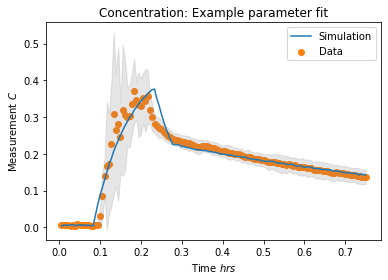

In [6]:
E_true, lambda_1_true, lambda_2_true = np.array([205,11.6,0.97])
param = {"E": E_true,  "lambda_1":lambda_1_true, "lambda_2":lambda_2_true}
true_trajectory = model(param)["Concentration"]
import matplotlib.pyplot as plt

plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.fill_between(measurement_times, measurement_data - data["stdev"], measurement_data + data["stdev"],color='gray', alpha=0.2)
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
#plt.plot(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Measurement $C$')
plt.title('Concentration: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

## Set up the ABC algorithm

Set up the ABC algorithm - we will use the ABC-SMC algorithm
This runs millions of different combinations of parameters and compares the model output to the data. If the distance between the predicted curves and the observed data is 'small enough', then the parameters are accepted. The distance is calculated using the sum of the squared differences between the model and the data.

In [7]:
def distance(simulation, data):
    return (np.absolute((data["Concentration"] - simulation["Concentration"]))).sum()

Define the prior distributions for the parameters. We will use uniform priors for all parameters.

In [8]:
parameter_prior = Distribution(
    E=RV("uniform", 10, 250), lambda_1=RV("uniform", 1, 10),lambda_2=RV("uniform", 0.5, 5))
parameter_prior.get_parameter_names()

['E', 'lambda_1', 'lambda_2']

This is the function that will be called by the ABC algorithm. It takes a set of parameters and returns the distance between the model and the data.

In [11]:
#new distance code
from pyabc.populationstrategy import AdaptivePopulationSize
#from functools import partial
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import QuantileEpsilon

from functools import partial
#PCMAD with Manhattan Distance
scale_log_file_pcmad = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,  # new, previously mad
    scale_log_file=scale_log_file_pcmad,
)

abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=AdaptivePopulationSize(start_nr_particles=1000, mean_cv=0.2),
    transitions=LocalTransition(k_fraction=0.3),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True)
)


ABC.Sampler INFO: Parallelize sampling on 8 processes.


This tells the abc model where the experimental data is.

In [12]:
observed_data_np = {"Concentration": measurement_data.to_numpy()}


In [13]:
#abc.new(db_path, {"Concentration": measurement_data, "stdev": data['stdev']}); ordinary distance function
abc.new(db_path, observed_data_np);

ABC.History INFO: Start <ABCSMC id=1, start_time=2023-05-31 09:12:49>


This runs the algorithm

In [14]:
#h = abc.run(minimum_epsilon=0.5, max_nr_populations=10)
h = abc.run(max_nr_populations=15)

ABC INFO: Calibration sample t = -1.
ABC.Distance INFO: Features ['Concentration:7', 'Concentration:15', 'Concentration:16', 'Concentration:23', 'Concentration:120', 'Concentration:121', 'Concentration:122', 'Concentration:123', 'Concentration:124', 'Concentration:125', 'Concentration:126', 'Concentration:127', 'Concentration:128', 'Concentration:129', 'Concentration:130', 'Concentration:131', 'Concentration:132', 'Concentration:133', 'Concentration:134'] (ixs=[  7  15  16  23 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134]) have a high bias.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 7.29382891e+01.
ABC INFO: Accepted: 1000 / 2047 = 4.8852e-01, ESS: 1.0000e+03.
ABC.Adaptation INFO: Change nr particles 1000 -> 192
ABC.Distance INFO: Features ['Concentration:7', 'Concentration:15', 'Concentration:16', 'Concentration:23', 'Concentration:121', 'Concentration:122', 'Concentration:123', 'Concentration:124', 'Concentration:125', 'Concentra

Visualization of the probability density functions for $E$ and $\lambda_1$

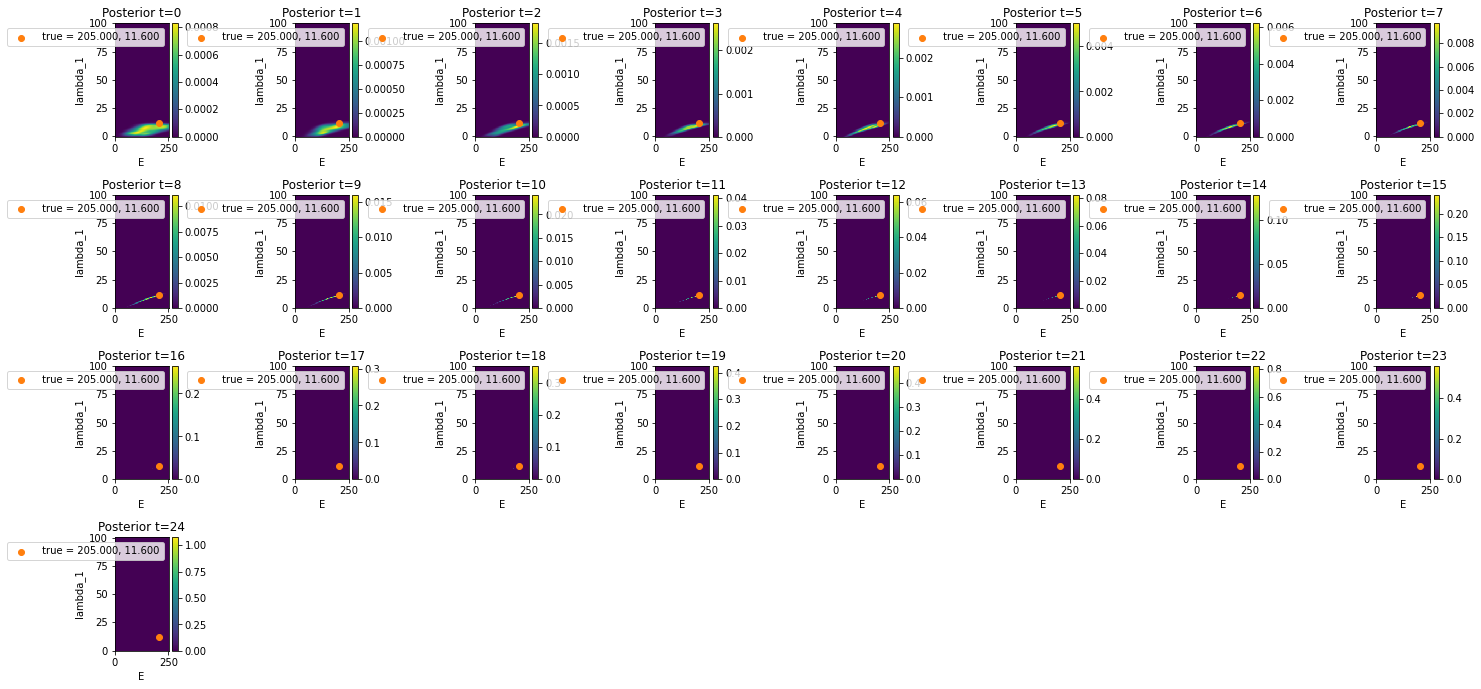

In [16]:
fig = plt.figure(figsize=(20, 14))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(6, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_1",
        
        xmin=0,   #xmin=0
        xmax=250,  #xmax=30
        numx=250, #numx=200
        ymin=0,   #ymin=0
        ymax=100,  #ymax=10
        numy=200, #numy=200
        ax=ax,    #ax=ax
    )
    ax.scatter(
        [E_true],
        [lambda_1_true],
        
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_1_true,
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Visualization of the probability density functions for $E$ and $\lambda_2$

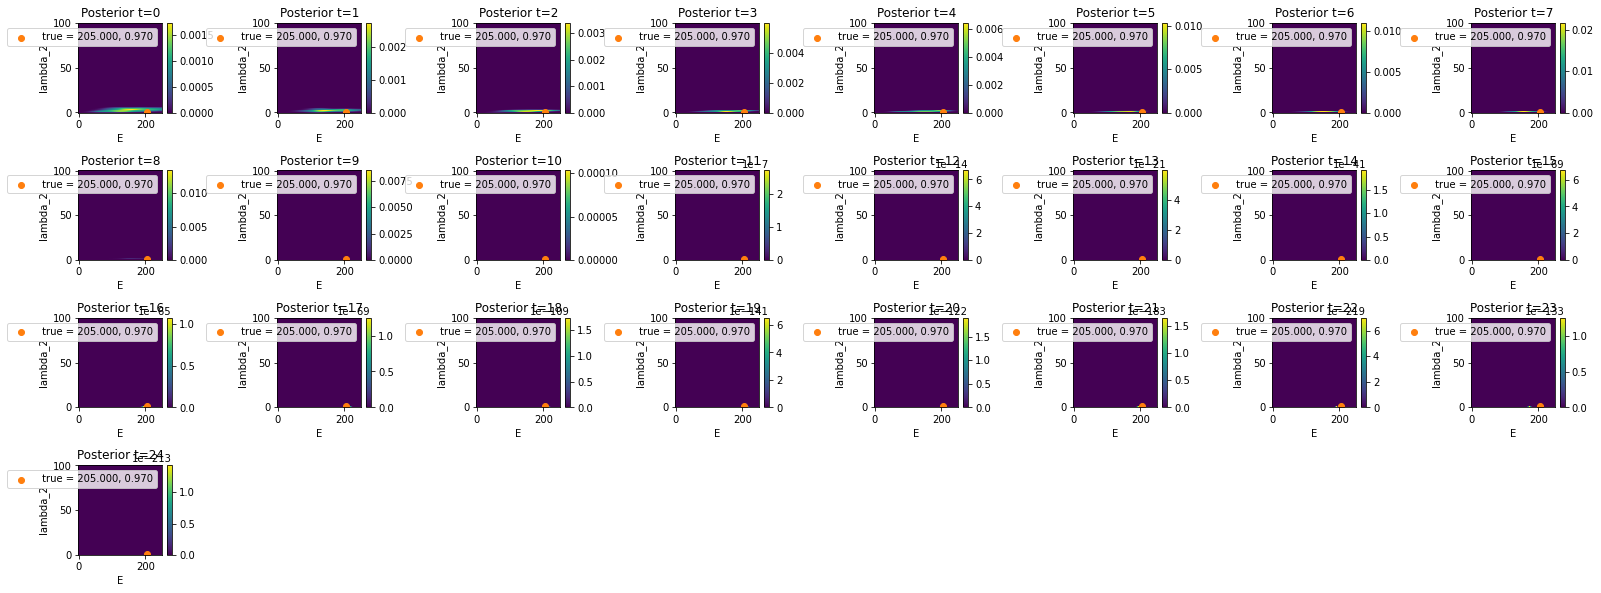

In [17]:
fig = plt.figure(figsize=(22, 12))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(6, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_2",
        
        xmin=0,   #xmin=0
        xmax=250,  #xmax=30
        numx=250, #numx=200
        ymin=0,   #ymin=0
        ymax=100,  #ymax=10
        numy=200, #numy=200
        ax=ax,    #ax=ax
    )
    ax.scatter(
        [E_true],
        [lambda_2_true],
        
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_2_true,
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

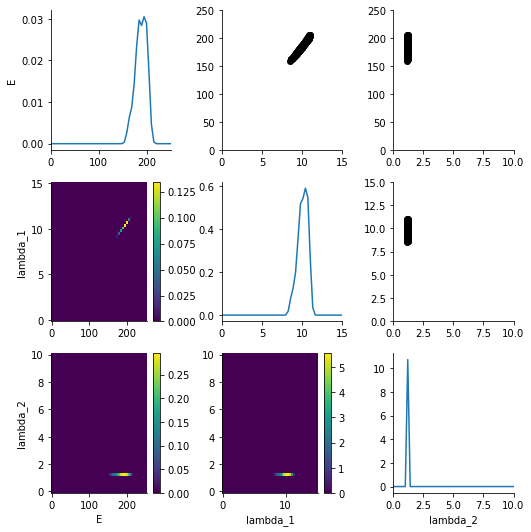

In [15]:
from pyabc.visualization import plot_kde_matrix

limits = dict(E=(0, 250),lambda_1=(0, 15),lambda_2=(0, 10))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

##We plot a 1000 simulated curves using the posterior distributions of the parameters

We can also plot the simulated trajectories:

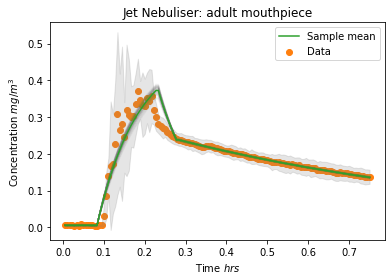

In [16]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.01)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
#plt.errorbar(measurement_times,measurement_data,yerr=data["stdev"], label ="Data",color='C1')
plt.fill_between(measurement_times, measurement_data - data["stdev"], measurement_data + data["stdev"],color='gray', alpha=0.2)
plt.xlabel('Time $hrs$')
plt.ylabel('Concentration $mg/m^3$')
plt.title('Jet Nebuliser: adult mouthpiece')
plt.legend()
plt.show()


Summary table of parameters

In [17]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.describe()


name,E,lambda_1,lambda_2,w
count,207.000000,207.000000,207.000000,207.000000
mean,187.834536,10.095700,1.199580,0.004821
std,10.911222,0.587903,0.021197,0.001565
min,160.054000,8.519000,1.147000,0.003000
25%,180.453500,9.700000,1.186000,0.004000
50%,189.412000,10.183000,1.198000,0.005000
75%,196.166500,10.562000,1.216000,0.005000
max,205.587000,10.976000,1.251000,0.015000


# 4.0 Risk prediction

In [26]:
# Caculate the concentration at each time point of the top 1 parameter combination in df using the ode model
param = df.iloc[0,:-1].to_dict()
C = model(param)["Concentration"]



In [27]:
import numpy as np
from scipy.integrate import cumtrapz

def calculate_dose(C, d, p, dt):

    """
    Calculate the total dose inhaled over time.
    Parameters:

    C: numpy array of drug concentration in the air over time
    d: fraction of the drug that is retained in the body
    p: breathing volume/hour
    dt: time step size

    Returns:
    D: numpy array of total dose inhaled over time

    """
    
    dD_dt = d*p*C
    D = cumtrapz(dD_dt, dx=dt, initial=0)
    return D

    """
    d = 40% for VMN and 70% for JN 
    p = 1.38 m^3/hr for light activity. From EPA Exposure Factors,Light defined as walking at speed level 1.5−3.0 mph (see Table 6-40 for original data).
    p = 0.54 m^3/hr for sedentary activity. From EPA Exposure Factors,sedentary activity defined as sitting and standing
    
    """
#observed_data_np = np.array()
d = 0.70
p = 0.54

dose = calculate_dose(C, d, p, dt=20/3600)



[0.00000000e+00 1.25816432e-05 2.60801431e-05 4.03312894e-05
 5.32966736e-05 6.47160949e-05 7.69869864e-05 8.95774053e-05
 1.02660731e-04 1.13464328e-04 1.21513383e-04 1.29013033e-04
 1.36697937e-04 1.47328291e-04 1.58503716e-04 1.97984288e-04
 2.94479291e-04 4.41782794e-04 6.36525307e-04 8.78928445e-04
 1.16385272e-03 1.48998765e-03 1.85851617e-03 2.26235227e-03
 2.69995422e-03 3.17262931e-03 3.67629330e-03 4.20862854e-03
 4.76713528e-03 5.35071745e-03 5.95974125e-03 6.59278831e-03
 7.24709874e-03 7.92175342e-03 8.61638722e-03 9.32956641e-03
 1.00603736e-02 1.08063553e-02 1.15681175e-02 1.23464593e-02
 1.31386842e-02 1.39381772e-02 1.47147436e-02 1.54451319e-02
 1.61344021e-02 1.67852678e-02 1.73967518e-02 1.79725645e-02
 1.85164468e-02 1.90315053e-02 1.95324171e-02 2.00307754e-02
 2.05268305e-02 2.10198817e-02 2.15076017e-02 2.19916850e-02
 2.24725087e-02 2.29484634e-02 2.34214795e-02 2.38925094e-02
 2.43601443e-02 2.48237177e-02 2.52855293e-02 2.57452450e-02
 2.61999744e-02 2.665152

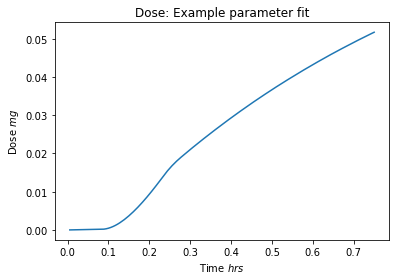

In [28]:
#plot the dose over time
plt.plot(measurement_times, dose)
plt.xlabel('Time $hrs$')
plt.ylabel('Dose $mg$')
plt.title('Dose: Example parameter fit')
plt.show()
